# Multiclass Classification Using CNN and Transfer Learning on [Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset/data)
 
## Idea behind using CNN and Transfer Learning

- I initially built a Convolutional Neural Network (CNN) model from scratch to perform multiclass classification.
- After establishing a baseline with the custom CNN, I utilized transfer learning by implementing the ResNet101 model.
- Transfer learning helps leverage the pre-trained features learned on a large dataset, such as ImageNet, to improve the accuracy and efficiency of our specific task.
- ResNet101 is known for its deep architecture and ability to handle complex features, making it suitable for tasks that involve diverse and detailed image data.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import sys
import time
from torchvision import datasets
import torch
import torchvision
import torchvision.transforms as T   # library provides all transformations for images
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import os
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
class vegetableDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.class_names = os.listdir(os.path.join(root_dir, split))
        self.samples = []
        
        # Load the data
        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, split, class_name)
            for filename in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, filename), self.class_names.index(class_name)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Importing the data, transformations and creating DataLoaders

In [6]:
# Define the preprocessing transforms
transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Load the data
train_dataset = vegetableDataset(root_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Python_code\\DL_project\\vegetable', split='train', transform=transform)
val_dataset = vegetableDataset(root_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Python_code\\DL_project\\vegetable', split='validation', transform=transform)
test_dataset = vegetableDataset(root_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Python_code\\DL_project\\vegetable', split='test', transform=transform)

# Create a DataLoader for the training dataset
batchSize = 32
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False, drop_last=True)


In [8]:
# Check shape of individual batches
for X, y in train_loader:
    print("Train Loader:")
    print("Batch images shape:", X.shape)  
    print("Batch labels shape:", y.shape, '\n')  
    break  
    
for X, y in val_loader:
    print("Validation Loader:")
    print("Batch images shape:", X.shape)  
    print("Batch labels shape:", y.shape, '\n')  
    break  

for X, y in test_loader:
    print("Test Loader:")
    print("Batch images shape:", X.shape)  
    print("Batch labels shape:", y.shape, '\n')  
    break


Train Loader:
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels shape: torch.Size([32]) 

Validation Loader:
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels shape: torch.Size([32]) 

Test Loader:
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels shape: torch.Size([32]) 



In [9]:
print(f"Number of training samples: {len(train_loader.dataset.samples)}")
print(f"Number of validation samples: {len(val_loader.dataset.samples)}")
print(f"Number of testing samples: {len(test_loader.dataset.samples)}")

Number of training samples: 15000
Number of validation samples: 3000
Number of testing samples: 3000


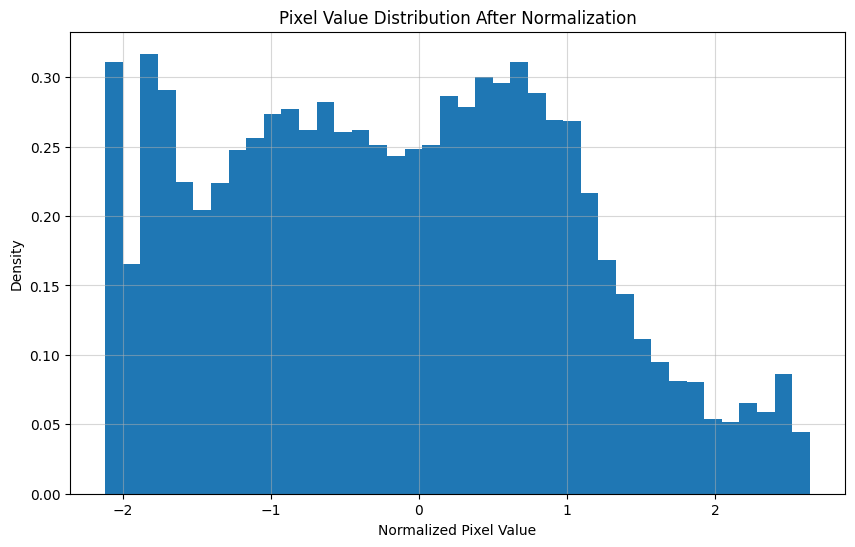

In [10]:
# Making sure that the data loaders are normalized 
images, _ = next(iter(train_loader))


flattened_images = images.view(-1)


flattened_images_np = flattened_images.numpy()

plt.figure(figsize=(10, 6))
plt.hist(flattened_images_np, bins=40, density=True)
plt.title('Pixel Value Distribution After Normalization')
plt.xlabel('Normalized Pixel Value')
plt.ylabel('Density')


plt.grid(True, alpha=0.5)
plt.show()

# Building the CNN model from scratch

In [11]:
# Hyperparameters
img_size = [128, 128]
kernel_size = 3
stride = 1
padding = 1  
window_size = 2  # for pooling
learning_rate = 0.001
l2_lambda = 1e-3

def makeTheNet():
    class vegetableNet(nn.Module):
        def __init__(self):
            super().__init__()

            # conv layer 1 + adding batch normalization
            self.conv1 = nn.Conv2d(3, 64, kernel_size, stride, padding)
            self.bnorm1 = nn.BatchNorm2d(64)  
            conv1_imgSize = np.floor((img_size[0] + 2*padding - kernel_size) / stride) + 1
            post_pooling_conv1 = np.floor(conv1_imgSize / window_size).astype(int)
    
            # conv layer 2 + adding batch normalization
            self.conv2 = nn.Conv2d(64, 128, kernel_size, stride, padding)
            self.bnorm2 = nn.BatchNorm2d(128)
            conv2_imgSize = np.floor((post_pooling_conv1 + 2*padding - kernel_size) / stride) + 1
            post_pooling_conv2 = np.floor(conv2_imgSize / window_size).astype(int)

            # conv layer 3 + adding batch normalization
            self.conv3 = nn.Conv2d(128, 256, kernel_size, stride, padding)
            self.bnorm3 = nn.BatchNorm2d(256)
            conv3_imgSize = np.floor((post_pooling_conv2 + 2*padding - kernel_size) / stride) + 1
            post_pooling_conv3 = np.floor(conv3_imgSize / window_size).astype(int)

            # conv layer 4 + adding batch normalization
            self.conv4 = nn.Conv2d(256, 512, kernel_size, stride, padding)
            self.bnorm4 = nn.BatchNorm2d(512)
            conv4_imgSize = np.floor((post_pooling_conv3 + 2*padding - kernel_size) / stride) + 1
            post_pooling_conv4 = np.floor(conv4_imgSize / window_size).astype(int)

            # conv layer 5 + adding batch normalization
            self.conv5 = nn.Conv2d(512, 512, kernel_size, stride, padding)
            self.bnorm5 = nn.BatchNorm2d(512)
            conv5_imgSize = np.floor((post_pooling_conv4 + 2*padding - kernel_size) / stride) + 1
            post_pooling_conv5 = np.floor(conv5_imgSize / window_size).astype(int)

            # conv layer 6 + adding batch normalization
            self.conv6 = nn.Conv2d(512, 512, kernel_size, stride=2, padding=1)  # Increased stride
            self.bnorm6 = nn.BatchNorm2d(512)
            conv6_imgSize = np.floor((post_pooling_conv5 + 2*1 - kernel_size) / 2) + 1  
            post_pooling_conv6 = np.floor(conv6_imgSize / window_size).astype(int)


            # Fully-connected layers
            self.fc1 = nn.Linear(post_pooling_conv6 * post_pooling_conv6 * 512, 1024)
            self.output = nn.Linear(1024, 15)

        def forward(self, x):
            # relu -> bnorm -> max_pool -> conv
            x = F.relu(self.bnorm1(F.max_pool2d(self.conv1(x), window_size)))
            #print('first conv1 layer', x.shape)
            x = F.relu(self.bnorm2(F.max_pool2d(self.conv2(x), window_size)))
            #print('first conv2 layer', x.shape)
            x = F.relu(self.bnorm3(F.max_pool2d(self.conv3(x), window_size)))
            #print('first conv3 layer', x.shape)
            x = F.relu(self.bnorm4(F.max_pool2d(self.conv4(x), window_size)))
            #print('first conv4 layer', x.shape)
            x = F.relu(self.bnorm5(F.max_pool2d(self.conv5(x), window_size)))
            #print('first conv5 layer', x.shape)
            x = F.relu(self.bnorm6(F.max_pool2d(self.conv6(x), window_size)))
            #print('first conv6 layer', x.shape)
                
            # Reshaping for linear layer
            x = x.reshape(x.shape[0], -1)

            # Passing linear layer through relu
            x = F.relu(self.fc1(x))


            return self.output(x)

    vegetablenet = vegetableNet()

    lossfun = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(vegetablenet.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    return vegetablenet, lossfun, optimizer

In [12]:
## sanity-check
# test the model with one batch to make sure there are no errors
vegetablenet,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = vegetablenet(X)

print('\nOutput size:')
print(yHat.shape)

# now let's compute the loss, uninterpretable loss ofcourse
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 15])
 
Loss:
tensor(2.7298, grad_fn=<NllLossBackward0>)


In [13]:
summary(vegetablenet, (3, 128, 128) ,device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─Conv2d: 1-3                            [-1, 128, 64, 64]         73,856
├─BatchNorm2d: 1-4                       [-1, 128, 32, 32]         256
├─Conv2d: 1-5                            [-1, 256, 32, 32]         295,168
├─BatchNorm2d: 1-6                       [-1, 256, 16, 16]         512
├─Conv2d: 1-7                            [-1, 512, 16, 16]         1,180,160
├─BatchNorm2d: 1-8                       [-1, 512, 8, 8]           1,024
├─Conv2d: 1-9                            [-1, 512, 8, 8]           2,359,808
├─BatchNorm2d: 1-10                      [-1, 512, 4, 4]           1,024
├─Conv2d: 1-11                           [-1, 512, 2, 2]           2,359,808
├─BatchNorm2d: 1-12                      [-1, 512, 1, 1]           1,024
├─Linear: 1-13                          

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─Conv2d: 1-3                            [-1, 128, 64, 64]         73,856
├─BatchNorm2d: 1-4                       [-1, 128, 32, 32]         256
├─Conv2d: 1-5                            [-1, 256, 32, 32]         295,168
├─BatchNorm2d: 1-6                       [-1, 256, 16, 16]         512
├─Conv2d: 1-7                            [-1, 512, 16, 16]         1,180,160
├─BatchNorm2d: 1-8                       [-1, 512, 8, 8]           1,024
├─Conv2d: 1-9                            [-1, 512, 8, 8]           2,359,808
├─BatchNorm2d: 1-10                      [-1, 512, 4, 4]           1,024
├─Conv2d: 1-11                           [-1, 512, 2, 2]           2,359,808
├─BatchNorm2d: 1-12                      [-1, 512, 1, 1]           1,024
├─Linear: 1-13                          

# Training and evaluating the model

In [15]:
def function2traintestTheModel():
    numepochs = 25
    vegetablenet, lossfun, optimizer = makeTheNet()
    
    # Send model to the GPU
    vegetablenet.to(device)
    # Initialize losses / accuracies
    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)
    
    start_time = time.time()
    for epochi in range(numepochs):
        epoch_start_time = time.time()
        # train mode
        vegetablenet.train()
        
        # training
        batch_train_loss = []
        batch_train_acc = []
        for X, y in train_loader:
            # Send the data to the GPU
            X, y = X.to(device), y.to(device)
            
            yHat = vegetablenet(X)
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Appending losses, computing accuracy
            batch_train_loss.append(loss.item())
            batch_train_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
        # Storing results
        trainLoss[epochi] = np.mean(batch_train_loss)
        trainAcc[epochi] = 100 * np.mean(batch_train_acc)
        # eval mode
        vegetablenet.eval()
        
        with torch.no_grad():
            # Validation
            batch_val_loss = []
            batch_val_acc = []
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                
                yHat = vegetablenet(X)
                loss = lossfun(yHat, y)
                
                batch_val_loss.append(loss.item())
                batch_val_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            
            valLoss[epochi] = np.mean(batch_val_loss)
            valAcc[epochi] = 100 * np.mean(batch_val_acc)
            # Test
            batch_test_loss = []
            batch_test_acc = []
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                
                yHat = vegetablenet(X)
                loss = lossfun(yHat, y)
                
                batch_test_loss.append(loss.item())
                batch_test_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            
            testLoss[epochi] = np.mean(batch_test_loss)
            testAcc[epochi] = 100 * np.mean(batch_test_acc)
        
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        
        # Print progress
        sys.stdout.write(f"\rFinished epoch: {epochi+1}/{numepochs}, time: {epoch_time:.2f}s, total time: {total_time:.2f}s")
    
    print("\nTraining completed!")
    return trainLoss, valLoss, testLoss, trainAcc, valAcc, testAcc, vegetablenet

In [16]:
### Training takes around ~84 minutes on my RTX 4060 GPU laptop
trainLoss, valLoss, testLoss, trainAcc, valAcc, testAcc, vegetablenet = function2traintestTheModel()

Finished epoch: 25/25, time: 190.20s, total time: 4911.03s
Training completed!


# Plot the results

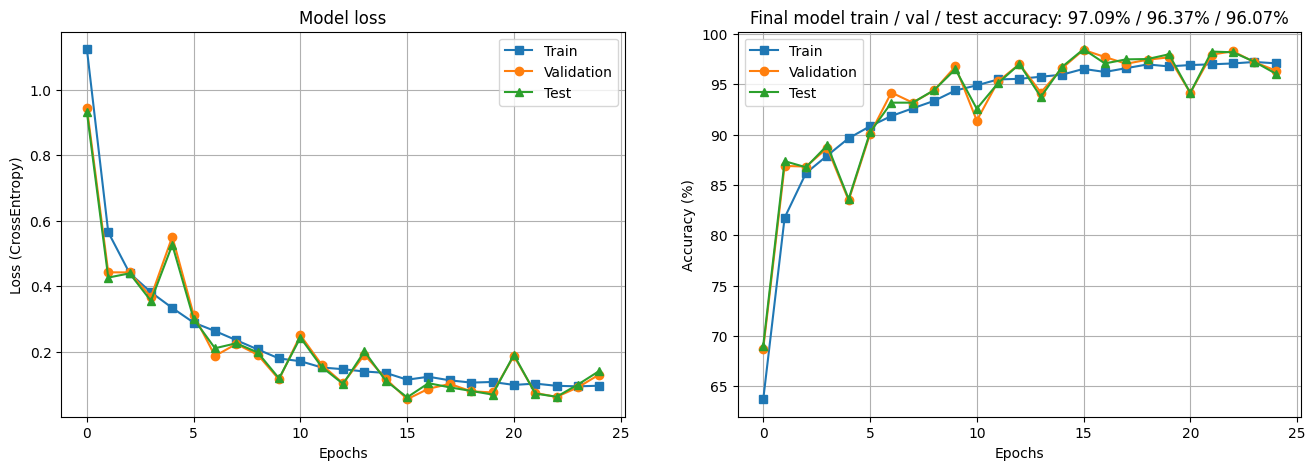

In [17]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(valLoss, 'o-', label='Validation')
ax[0].plot(testLoss, '^-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CrossEntropy)')
ax[0].set_title('Model loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(valAcc, 'o-', label='Validation')
ax[1].plot(testAcc, '^-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train / val / test accuracy: {trainAcc[-1]:.2f}% / {valAcc[-1]:.2f}% / {testAcc[-1]:.2f}%')
ax[1].legend()
ax[1].grid(True)

plt.show()

# Confusion Matrix on the CNN model

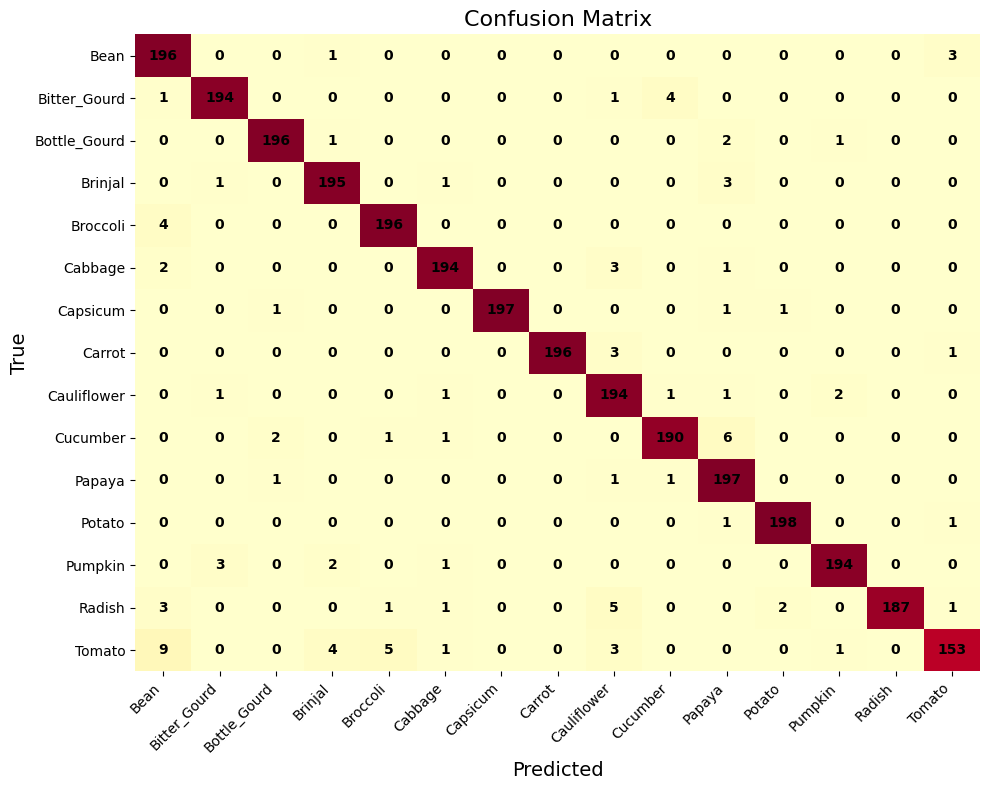

In [28]:
def plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    
    # Plot normalized confusion matrix
    sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    
    # Overlay raw counts as annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}', 
                     horizontalalignment='center', 
                     verticalalignment='center', 
                     fontsize=10, weight='bold', color='black')
    
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    
    plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
    
    plt.tight_layout()
    plt.show()

# Example usage
class_names = ["Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli", "Cabbage", "Capsicum", "Carrot", "Cauliflower", "Cucumber", "Papaya", "Potato", "Pumpkin", "Radish", "Tomato"]
plot_confusion_matrix(vegetablenet, test_loader, device, class_names)

# Saving the model

In [29]:
torch.save(vegetablenet.state_dict(), 'vegetable_classification_model.pth')

# Transfer learning on ResNet101

In [30]:
weights = torchvision.models.ResNet101_Weights.DEFAULT
resnet = torchvision.models.resnet101(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\MSII/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100%|███████████████████████████████████████████████████████████████████████████████| 171M/171M [00:04<00:00, 38.1MB/s]


In [31]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
summary(resnet.to(device),(3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 256, 32, 32]         --
|    └─Bottleneck: 2-1                   [-1, 256, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 32, 32]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 256, 32, 32]         --
|    └─Bottleneck: 2-1                   [-1, 256, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 32, 32]         16,38

In [33]:
# Freeze all layers
for p in resnet.parameters():
    p.requires_grad = False

In [34]:
# Replace the final layer to match our output features in the dataset
resnet.fc = nn.Linear(resnet.fc.in_features, 15)

In [35]:
resnet.to(device);

# Training and evaluating the ResNet model

In [36]:
lr = 0.001
l2 = 1e-3
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=l2)

In [37]:
def function2traintestTheModel():
    numepochs = 10
     
    # Initialize losses / accuracies
    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)
    
    start_time = time.time()
    for epochi in range(numepochs):
        epoch_start_time = time.time()
        
        # Train mode
        resnet.train()
        
        # Training
        batch_train_loss = []
        batch_train_acc = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            yHat = resnet(X)
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_train_loss.append(loss.item())
            batch_train_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
        
        trainLoss[epochi] = np.mean(batch_train_loss)
        trainAcc[epochi] = 100 * np.mean(batch_train_acc)
        
        # Eval mode
        resnet.eval()
        
        with torch.no_grad():
            # Validation
            batch_val_loss = []
            batch_val_acc = []
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                
                yHat = resnet(X)
                loss = lossfun(yHat, y)
                
                batch_val_loss.append(loss.item())
                batch_val_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            
            valLoss[epochi] = np.mean(batch_val_loss)
            valAcc[epochi] = 100 * np.mean(batch_val_acc)
            
            # Test
            batch_test_loss = []
            batch_test_acc = []
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                
                yHat = resnet(X)
                loss = lossfun(yHat, y)
                
                batch_test_loss.append(loss.item())
                batch_test_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            
            testLoss[epochi] = np.mean(batch_test_loss)
            testAcc[epochi] = 100 * np.mean(batch_test_acc)
        
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        
        # Print progress
        sys.stdout.write(f"\rFinished epoch: {epochi+1}/{numepochs}, time: {epoch_time:.2f}s, total time: {total_time:.2f}s")
    
    print("\nTraining completed!")
    return trainLoss, valLoss, testLoss, trainAcc, valAcc, testAcc, resnet

In [38]:
### Training takes around ~30 minutes on my RTX 4060 GPU laptop
trainLoss, valLoss, testLoss, trainAcc, valAcc, testAcc, resnet = function2traintestTheModel()

Finished epoch: 10/10, time: 179.04s, total time: 1837.49s
Training completed!


# Plot the results and the confusion matrix

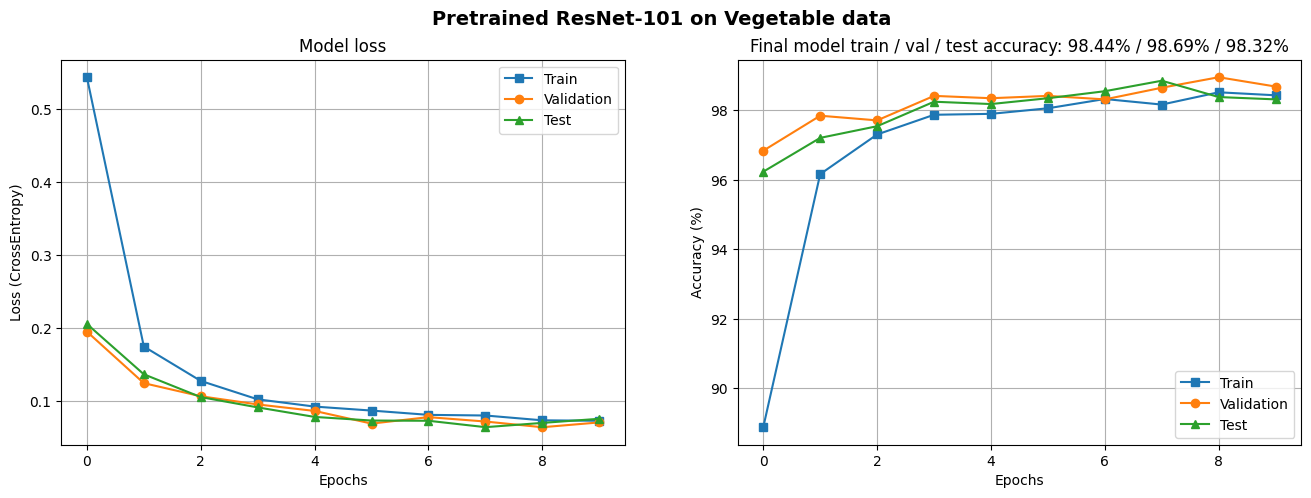

In [39]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(valLoss, 'o-', label='Validation')
ax[0].plot(testLoss, '^-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CrossEntropy)')
ax[0].set_title('Model loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(valAcc, 'o-', label='Validation')
ax[1].plot(testAcc, '^-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train / val / test accuracy: {trainAcc[-1]:.2f}% / {valAcc[-1]:.2f}% / {testAcc[-1]:.2f}%')
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Pretrained ResNet-101 on Vegetable data',fontweight='bold',fontsize=14)
plt.show()

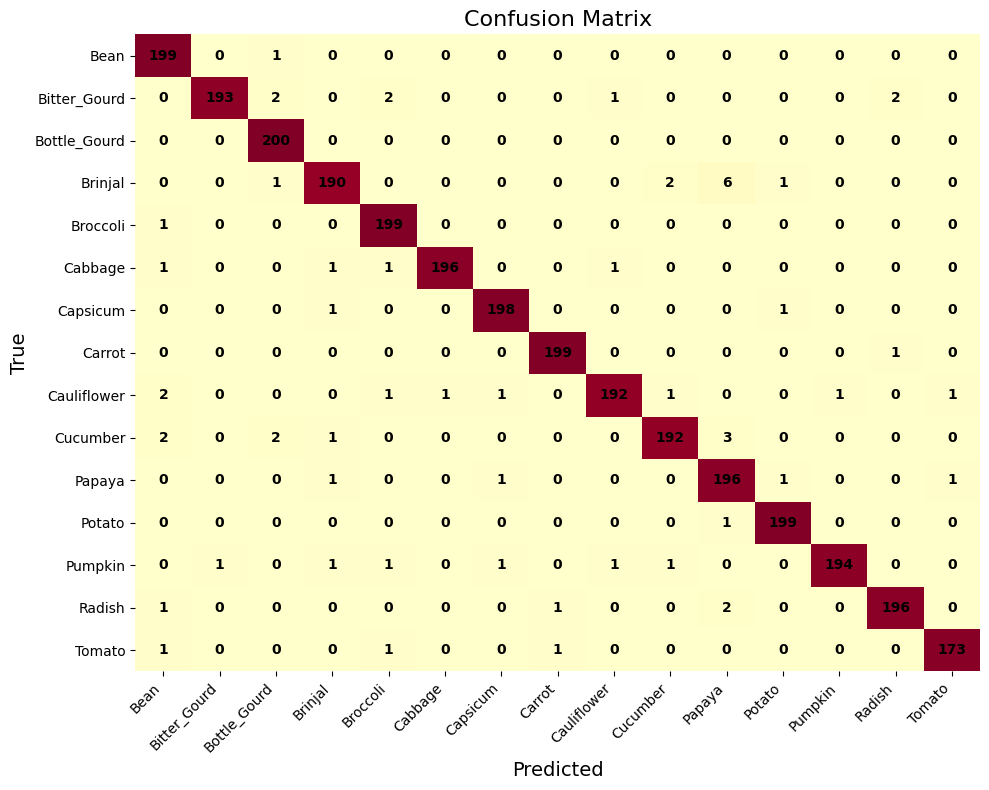

In [41]:
plot_confusion_matrix(resnet, test_loader, device, class_names)

# Comparing results

| Model         | Train Accuracy | Validation Accuracy | Test Accuracy | Computation Time |
|:--------------|---------------:|--------------------:|--------------:|-----------------:|
| **My Model**  | **97.09%**     | **96.37%**          | **96.07%**    | **~84 mins**     |
| **ResNet-101**| **98.44%**     | **98.69%**          | **98.32%**    | **~30 mins**     |


<p style="font-size:20px;"><strong>Based on the 2 models results, there isnt really a big difference in terms of the accuracy. However, in terms of computation time there is a big difference when it comes to the pretrained model, it takes around half the time of the model that I built.
</strong></p>